Import numpy and pandas

In [1]:
import numpy as np
import pandas as pd

Import matplotlib for graphing and enable graphs to be shown in the workbook

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

Read in the dataset using Pandas

In [3]:
df_const = pd.read_csv('ConstructionTimeSeriesDatav2.csv')

Take a look at the elements in the dataset and then get a picture of what that data looks like by plotting a graph. This graph is not a presentation graph, but simply a quick means of visualizing the data.

In [4]:
df_const.head()

,Month,Month-Year,Total Construction,Private Construction,Public Construction
0,1,Jan-02,59516,45273,14243
1,2,Feb-02,58588,44475,14113
2,3,Mar-02,63782,49396,14386
3,4,Apr-02,69504,53283,16221
4,5,May-02,73384,55009,18375


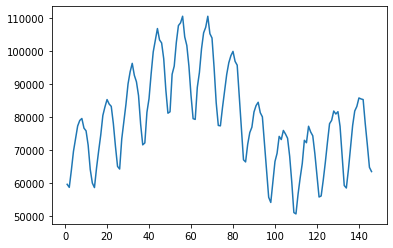

In [5]:
plt.plot(df_const['Month'],df_const['Total Construction'])

Looking at the total amount of construction over the time period covered in the data set, we start to see the data increase towards the beginning of the time range, only to later decrease down to or below original levels. Then the data potentially starts to increase again at the end of the range, however we would need more data points to confirm that.

Based on this plot, we can conclude that this data seems to exhibit a non-linear trend. We will likely follow the model presented in Example 2 of the lecture series.

It would also be interesting to view construction spending broken out by private and public, so we'll look at that next.

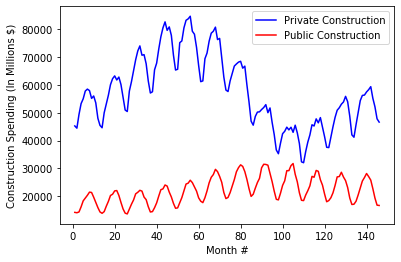

In [6]:
plt.plot(df_const['Month'],df_const['Private Construction'],color='blue',label='Private Construction')
plt.plot(df_const['Month'],df_const['Public Construction'],color='red',label='Public Construction')
plt.xlabel('Month #')
plt.ylabel('Construction Spending (In Millions $)')
plt.legend()

It's interesting to see that most, if not all, of the trend seen in total construction spending is shown in private construction spending. Private construction has consistently been at much higher levels than public construction, and so it makes sense that the overall trend would be more representative of private construction spending in this case.

Public construction spending doesn't clearly exhibit a linear trend either, with maybe slight increases and decreases over the time range (looks like a bow shape).

With all this in mind, we will model both private and public construction with a non-linear trend, as we did in Example 2 of Lecture.

The modeling equation for each data series could be represented as: $H\left(m \right) = T\left( m \right) + C\left( m \right) + \epsilon \left( m \right)$

We will begin with the private construction data series and decompose the series into its individual components:

In [7]:
def sqErr_Priv(row):
    return (row['Private Construction'] - row['MovAvg'])**2
    
df_const['MovAvg'] = np.NaN
df_const['sqErr_Priv'] = np.NaN

# Changing the DataFrame index to DatetimeIndex data type is required for using one of the functions below
df_const.index = pd.date_range(start='1/1/2002', periods = len(df_const['Private Construction']), freq='M')

#print(len(data),'\n',data)

window = 36
window = window - window % 2
for i in range(int(window/2),df_const.shape[0]-int(window/2)):
    df_const.loc[df_const.index[i],'MovAvg'] = (0.5*df_const.iloc[i - int(window/2)]['Private Construction'] + df_const.iloc[i - int(window/2)+1:i + int(window/2)]['Private Construction'].sum() + 0.5*df_const.iloc[i + int(window/2)]['Private Construction'])/float(window)

df_const['sqErr_Priv'] = df_const.apply(sqErr_Priv,axis='columns')

#print(data.head())
df_const.dropna(how='any',inplace=True)

C:\Users\micha\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Average Squared Error per Month:  37395667.05489795
            Month Month-Year  Total Construction  Private Construction  \
2003-07-31     19     Jul-03               82971                 62216   
2003-08-31     20     Aug-03               85191                 63234   
2003-09-30     21     Sep-03               83841                 61767   
2003-10-31     22     Oct-03               83133                 62813   
2003-11-30     23     Nov-03               77915                 60115   

            Public Construction        MovAvg    sqErr_Priv  
2003-07-31                20755  57969.430556  1.803335e+07  
2003-08-31                21957  58314.944444  2.419711e+07  
2003-09-30                22075  58718.902778  9.290897e+06  
2003-10-31                20321  59143.555556  1.346482e+07  
2003-11-30                17801  59593.541667  2.719188e+05  


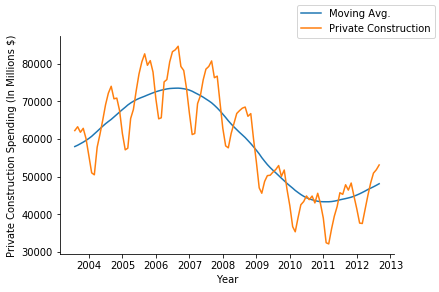

In [8]:
fig,ax = plt.subplots()

ax.plot(df_const['MovAvg'], label='Moving Avg.')
ax.plot(df_const['Private Construction'], label='Private Construction')
ax.set_xlabel('Year')
ax.set_ylabel('Private Construction Spending (In Millions $)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fig.legend()
print('Average Squared Error per Month: ',sum(df_const['sqErr_Priv'])/len(df_const))
print(df_const.head())

In [10]:
df_const['R1_Priv'] = df_const['Private Construction'] - df_const['MovAvg']
df_const['R1Error_Priv'] = abs((df_const['Private Construction'] - df_const['R1_Priv'])/df_const['Private Construction'])
df_const.style.format({
    'MovAvg': '{:.1f}'.format,
    'sqErr_Priv': '{:,.1f}'.format,
    'R1_Priv': '{:,.1f}'.format,
    'R1Error_Priv': '{:,.3f}'.format
})

,Month,Month-Year,Total Construction,Private Construction,Public Construction,MovAvg,sqErr_Priv,R1_Priv,R1Error_Priv
2003-07-31 00:00:00,19,Jul-03,82971,62216,20755,57969.4,"18,033,352.0","4,246.6",0.932
2003-08-31 00:00:00,20,Aug-03,85191,63234,21957,58314.9,"24,197,107.6","4,919.1",0.922
2003-09-30 00:00:00,21,Sep-03,83841,61767,22075,58718.9,"9,290,896.7","3,048.1",0.951
2003-10-31 00:00:00,22,Oct-03,83133,62813,20321,59143.6,"13,464,822.5","3,669.4",0.942
2003-11-30 00:00:00,23,Nov-03,77915,60115,17801,59593.5,"271,918.8",521.5,0.991
2003-12-31 00:00:00,24,Dec-03,71050,55584,15466,60111.7,"20,500,394.3","-4,527.7",1.081
2004-01-31 00:00:00,25,Jan-04,64934,50975,13959,60687.3,"94,329,418.8","-9,712.3",1.191
2004-02-29 00:00:00,26,Feb-04,64138,50449,13689,61335.4,"118,514,067.8","-10,886.4",1.216
2004-03-31 00:00:00,27,Mar-04,73238,57796,15443,62017.4,"17,820,241.4","-4,221.4",1.073
2004-04-30 00:00:00,28,Apr-04,78354,61177,17177,62701.1,"2,322,787.7","-1,524.1",1.025


Average Residual:  113.25315656565621


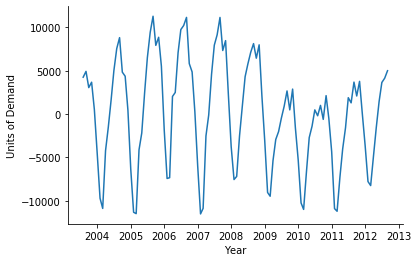

In [11]:
fig,ax = plt.subplots()
ax.plot(df_const['R1_Priv'])
ax.set_xlabel('Year')
ax.set_ylabel('Units of Demand')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
print('Average Residual: ', sum(df_const['R1_Priv'])/len(df_const))

In [12]:
maxCorr = 0.0
period = np.NaN
for i in range(1,37):
    corr = df_const['R1_Priv'].autocorr(lag=i)
    print('Correlation, lag ',i,'   ',corr)
    if corr > maxCorr:
        maxCorr = corr
        period = i
print('period = ',period,'     Maximum Correlation = ',maxCorr)

Correlation, lag  1     0.8250475036301713
Correlation, lag  2     0.4820939752221447
Correlation, lag  3     0.0661838628463355
Correlation, lag  4     -0.29310582259154694
Correlation, lag  5     -0.5386625150984725
Correlation, lag  6     -0.6496282831082484
Correlation, lag  7     -0.549838477475518
Correlation, lag  8     -0.3185413831731613
Correlation, lag  9     0.02011606382325631
Correlation, lag  10     0.41176952584284515
Correlation, lag  11     0.7322731003955263
Correlation, lag  12     0.8944851710984221
Correlation, lag  13     0.7299213692607464
Correlation, lag  14     0.4055214152186815
Correlation, lag  15     0.0031237974667481893
Correlation, lag  16     -0.34159925855108353
Correlation, lag  17     -0.5745510163732713
Correlation, lag  18     -0.681216824190257
Correlation, lag  19     -0.5902172854543253
Correlation, lag  20     -0.37531995989940625
Correlation, lag  21     -0.04750388422754723
Correlation, lag  22     0.3369494305895757
Correlation, lag  23   

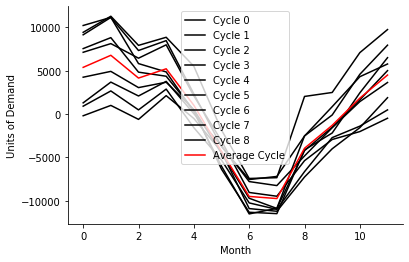

In [13]:
period = 12
cycleLen = period
numCycles = int(len(df_const)/cycleLen + 0.5)
cycles = [df_const.iloc[range(i*period,min((i+1)*period,len(df_const)))]['R1_Priv'] for i in range(numCycles)]
ptsInCycles = [df_const.iloc[range(i,len(df_const['R1_Priv']),period)]['R1_Priv'].tolist() for i in range(period)]
avg = [sum(pts)/len(pts) for pts in ptsInCycles]

fig,ax = plt.subplots()
for i in range(len(cycles)):
    ax.plot(cycles[i].values,label='Cycle '+str(i),c='k')
ax.plot(avg,label='Average Cycle',c='r')
ax.set_xlabel('Month')
ax.set_ylabel('Units of Demand')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend()

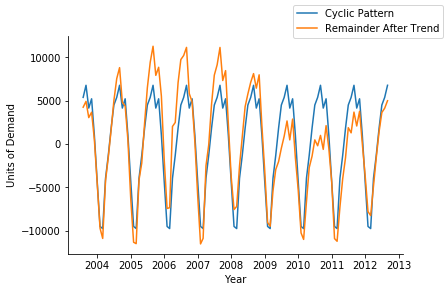

In [14]:
cycleLen = period   # see prior cell for computation of cyclicality period
numCycles = int(len(df_const)/cycleLen + 0.5)
df_const['C'] = np.NaN   # Creates an empty column for the cyclicality component data
for i in range(len(df_const)):
    df_const.loc[df_const.index[i], 'C'] = avg[i % cycleLen] # Write appropriate cyclicality value

fig,ax = plt.subplots()
ax.plot(df_const['C'],label='Cyclic Pattern')
ax.plot(df_const['R1_Priv'],label='Remainder After Trend')
ax.set_xlabel('Year')
ax.set_ylabel('Units of Demand')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.legend()

Average Error:  0.037815969902102356
            Month Month-Year  Total Construction  Private Construction  \
2003-07-31     19     Jul-03               82971                 62216   
2003-08-31     20     Aug-03               85191                 63234   
2003-09-30     21     Sep-03               83841                 61767   
2003-10-31     22     Oct-03               83133                 62813   
2003-11-30     23     Nov-03               77915                 60115   
2003-12-31     24     Dec-03               71050                 55584   
2004-01-31     25     Jan-04               64934                 50975   
2004-02-29     26     Feb-04               64138                 50449   
2004-03-31     27     Mar-04               73238                 57796   
2004-04-30     28     Apr-04               78354                 61177   
2004-05-31     29     May-04               83736                 65027   
2004-06-30     30     Jun-04               89932                 69039   
2

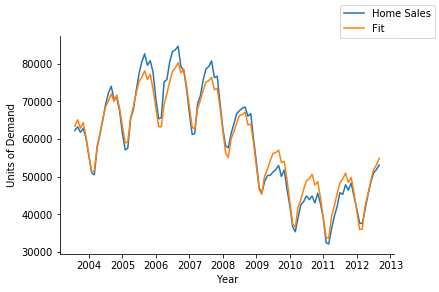

In [15]:
df_const['R2_Priv'] = df_const['R1_Priv'] - df_const['C']
df_const['R2Error_Priv'] = abs(df_const['R2_Priv']/df_const['Private Construction'])
df_const['fit_Priv'] = df_const['MovAvg'] + df_const['C']
df_const.drop(['sqErr_Priv'],axis=1,inplace=True)
print('Average Error: ', sum(df_const['R2Error_Priv'])/len(df_const))
print(df_const)
fig,ax = plt.subplots()
ax.plot(df_const['Private Construction'],label='Home Sales')
ax.plot(df_const['fit_Priv'], label = 'Fit')
ax.set_xlabel('Year')
ax.set_ylabel('Units of Demand')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.legend()

Correlation, lag  1     0.9027847832948318
Correlation, lag  2     0.7955702460094589
Correlation, lag  3     0.6560564735350041
Correlation, lag  4     0.5316739965331645
Correlation, lag  5     0.40216413631183895
Correlation, lag  6     0.3295267465640479
Correlation, lag  7     0.30585196484336047
Correlation, lag  8     0.330740986282625
Correlation, lag  9     0.3513528536369925
Correlation, lag  10     0.39197130708064265
Correlation, lag  11     0.42152079795616615
Correlation, lag  12     0.45317295658989853
Correlation, lag  13     0.39968224552326453
Correlation, lag  14     0.35553340791809884
Correlation, lag  15     0.2609189789415448
Correlation, lag  16     0.19032184469495012
Correlation, lag  17     0.12087743508505222
Correlation, lag  18     0.09559969424180809
Correlation, lag  19     0.09972184559354913
Correlation, lag  20     0.11683883938478473
Correlation, lag  21     0.12449790662917444
Correlation, lag  22     0.1325196757849622
Correlation, lag  23     0.13

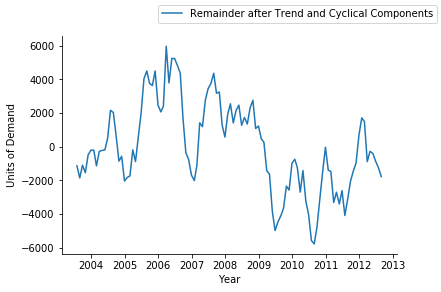

In [16]:
fig,ax = plt.subplots()
ax.plot(df_const['R2_Priv'],label='Remainder after Trend and Cyclical Components')
ax.set_xlabel('Year')
ax.set_ylabel('Units of Demand')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.legend()
maxCorr = 0.0
period = np.NaN
for i in range(1,37):
    corr = df_const['R2_Priv'].autocorr(lag=i)
    print('Correlation, lag ',i,'   ',corr)
    if corr > maxCorr:
        maxCorr = corr
        period = i
print('period = ',period,'     Maximum Correlation = ',maxCorr)

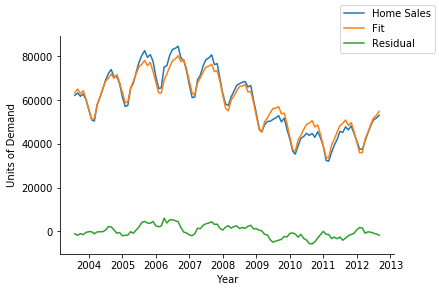

In [17]:
fig,ax = plt.subplots()
ax.plot(df_const['Private Construction'],label='Home Sales')
ax.plot(df_const['fit_Priv'],label='Fit')
ax.plot(df_const['R2_Priv'],label='Residual')
ax.set_xlabel('Year')
ax.set_ylabel('Units of Demand')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.legend()